In [1]:
import numpy as np 
import h5py 
from ldc.lisa.noise import get_noise_model
import matplotlib.pyplot as plt
import scipy

Load in Yorsch Dataset

In [2]:
Yorsch = h5py.File('yorsh_training_sobhb.h5', 'r')

Extract the times over which the Yorsch dataset contains data, and construct frequency grid from this 

In [3]:
times = Yorsch['instnoise']['tdi']['t'].flatten()

# Cadence
cadence = np.diff(times)[0]
freqs_all = np.fft.rfftfreq(n = times.size,d = cadence)

# Sensible fmin here of 0.001 for integration, no sources in Yorsch go below this 
freqs = freqs_all[freqs_all>0.001]

Use the LDC LISA noise curve to create the PSD over this range 

In [4]:
noise = get_noise_model("sangria", freqs, wd=0)
PSD_A = noise.psd(freqs, option='A', tdi2 = True)
PSD_E = noise.psd(freqs, option='E', tdi2 = True)
PSD_T = noise.psd(freqs, option='T', tdi2 = True)
psd = np.array([PSD_A,PSD_E,PSD_T])

In [5]:
def XYZ2AET(X, Y, Z):
    """
    Convert TDI from XYZ to AET.

    Args:
        X (scalar or NumPy Array): X component
        Y (scalar or NumPy Array): Y component
        Z (scalar or NumPy Array): Z component

    Returns:
        A (float or NumPy Array): A component (same dimensions as X, Y, Z)
        E (float or NumPy Array): E component (same dimensions as X, Y, Z)
        T (float or NumPy Array): T component (same dimensions as X, Y, Z)
    """

    A = (Z - X) / 2.0**0.5
    E = (X - 2.0*Y + Z) / 6.0**0.5
    T = (X + Y + Z) / 3.0**0.5

    return A, E, T

Convert instrumental noise in Yorsch from XYZ to AET, window and compare to periodogram

In [6]:

# Windowing
win = scipy.signal.windows.tukey(len(times), alpha=0.1)

X_noise,Y_noise,Z_noise = Yorsch['instnoise']['tdi']['X'][:,0]*win,Yorsch['instnoise']['tdi']['Y'][:,0]*win,Yorsch['instnoise']['tdi']['Z'][:,0]*win

# Convert from XYZ to AET 
A_noise, E_noise, T_noise =  XYZ2AET(X_noise, Y_noise, Z_noise)

# Take FFT
_f, PSD_A_welch =  scipy.signal.welch(A_noise, fs=1.0/cadence, window='hann', nperseg=256*256)
_f, PSD_E_welch =  scipy.signal.welch(E_noise, fs=1.0/cadence, window='hann', nperseg=256*256)
_f, PSD_T_welch =  scipy.signal.welch(T_noise, fs=1.0/cadence, window='hann', nperseg=256*256)




Welch periodogram of the instrumental noise in each channel

Text(0, 0.5, 'PSD $1/\\sqrt{Hz}$')

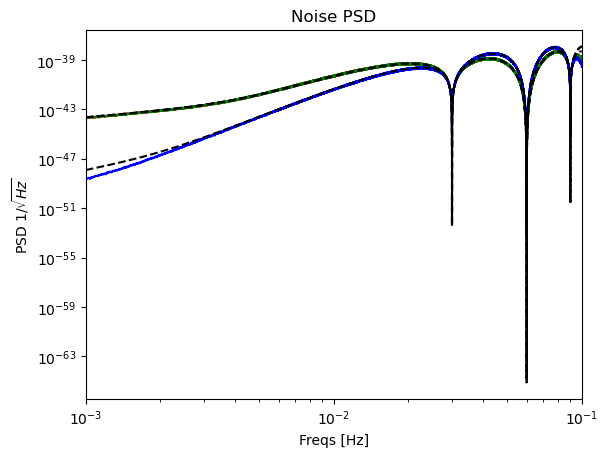

In [7]:
plt.title('Noise PSD')
plt.xlim(0.001,0.1)
plt.loglog(_f, PSD_A_welch, label='Welch A estimate',color='r')
plt.loglog(_f, PSD_E_welch, label='Welch E estimate',color='g')
plt.loglog(_f, PSD_T_welch, label='Welch T estimate',color='b')

plt.loglog(freqs,PSD_A,color='k',linestyle='--')
plt.loglog(freqs,PSD_E,color='k',linestyle='--')
plt.loglog(freqs,PSD_T,color='k',linestyle='--')
plt.xlabel('Freqs [Hz]')
plt.ylabel(r'PSD $1/\sqrt{Hz}$')

Now that we are pretty sure the PSDs are mostly okay, compute the SNR of each of the signals with this PSD.

In [12]:
sobbh_indexes = [1,2,3,5,6,8,9,10]
df = np.diff(freqs)[0]
for sobbh_index in sobbh_indexes: 
    # Signal only waveform extraction
    signal_only = Yorsch['noisefree']['sobhb'+str(sobbh_index)]['tdi'][()]
    signal_X,signal_Y,signal_Z = signal_only['X'][:,0],signal_only['Y'][:,0],signal_only['Z'][:,0]

    # Take FFT 
    fft_X = np.fft.rfft(signal_X*win)*cadence
    fft_Y = np.fft.rfft(signal_Y*win)*cadence
    fft_Z = np.fft.rfft(signal_Z*win)*cadence

    fft_A,fft_E,fft_T = XYZ2AET(fft_X, fft_Y, fft_Z)
    
    data = np.array([fft_A,fft_E,fft_T])[:,freqs_all>0.001]
        
    SNR = np.sqrt(np.real(4*np.sum(data*data.conj()/psd*df)))
    print('SOBBH: ',sobbh_index,' SNR: ',SNR)
    
        

SOBBH:  1  SNR:  10.91029549366007
SOBBH:  2  SNR:  4.067883524212445
SOBBH:  3  SNR:  9.888076587673945
SOBBH:  5  SNR:  12.935675777688932
SOBBH:  6  SNR:  14.30856423746152
SOBBH:  8  SNR:  24.367086558772378
SOBBH:  9  SNR:  23.081812571890033
SOBBH:  10  SNR:  24.65162435823996
